In this notebook I will analyze and do some modelling on the Elliptic Data Set.
<p>
The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

In [0]:
!mkdir kaggle

In [0]:
!pip install kaggle

In [0]:
import os
os.chdir('../root')

In [0]:
!mkdir .kaggle

In [0]:
os.chdir('.kaggle')

In [0]:
import json
token ={"username":"","key":""}
with open('kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 kaggle.json

In [0]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
bradklassen/pga-tour-20102018-data                          PGA Tour Golf Data                                   92MB  2019-08-20 10:32:59           3378  
AnalyzeBoston/crimes-in-boston                              Crimes in Boston                                     10MB  2018-09-04 17:56:03          11080  
matheusfreitag/gas-prices-in-brazil                         Gas Prices in Brazil                                  3MB  2019-07-12 16:23:52           5957  
jealousleopard/goodreadsbooks                               Goodreads-books                                     632KB  2019-06-14 16:35:05           9917  
wkirgsn/electric-motor-temperature                          Elec

In [0]:
os.chdir('../../content/kaggle')

In [0]:
!kaggle datasets download -d ellipticco/elliptic-data-set

 96% 137M/142M [00:02<00:00, 47.0MB/s]
100% 142M/142M [00:02<00:00, 70.4MB/s]


In [0]:
!unzip elliptic-data-set.zip

Archive:  elliptic-data-set.zip
   creating: elliptic_bitcoin_dataset/
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  
   creating: __MACOSX/
   creating: __MACOSX/elliptic_bitcoin_dataset/
  inflating: __MACOSX/elliptic_bitcoin_dataset/._elliptic_txs_features.csv  


In [0]:
os.chdir('..')

In [0]:
import pandas as pd
import numpy as np
import os
from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(2019)

import matplotlib.pyplot as plt
import seaborn as sns

PATH = 'kaggle/elliptic_bitcoin_dataset/'

In [0]:
df_classes = pd.read_csv(PATH + 'elliptic_txs_classes.csv')
df_features = pd.read_csv(PATH + 'elliptic_txs_features.csv', header=None)
df_edgelist = pd.read_csv(PATH + 'elliptic_txs_edgelist.csv')

## EDA

Let's look at the tables and build some intuition about the dataset
<p>
This anonymized data set is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.

<b> Nodes and edges </b>
<p>
The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.
    

<b> Features </b>
<p>
There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks. Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

In [0]:
# class of each transaction table
df_classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [0]:
# features collected for each node
df_features.head()
df_features.columns = ['id', 'time step'] + [f'trans_feat_{i}' for i in range(93)] \
+ [f'agg_feat_{i}' for i in range(72)]

In [0]:
# edge list between bitcoin transaction nodes
df_edgelist.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


Let's plot the histogram of different classes of transactions

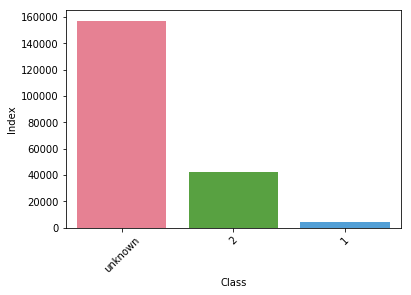

In [0]:
# Distribution of target values

g1 = sns.countplot(df_classes['class'].values, palette="husl")
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)

g1.set_xlabel("Class")
g1.set_ylabel("Index");

Plot correlations between features, to better understand if some columns in our dataset are somehow repeated

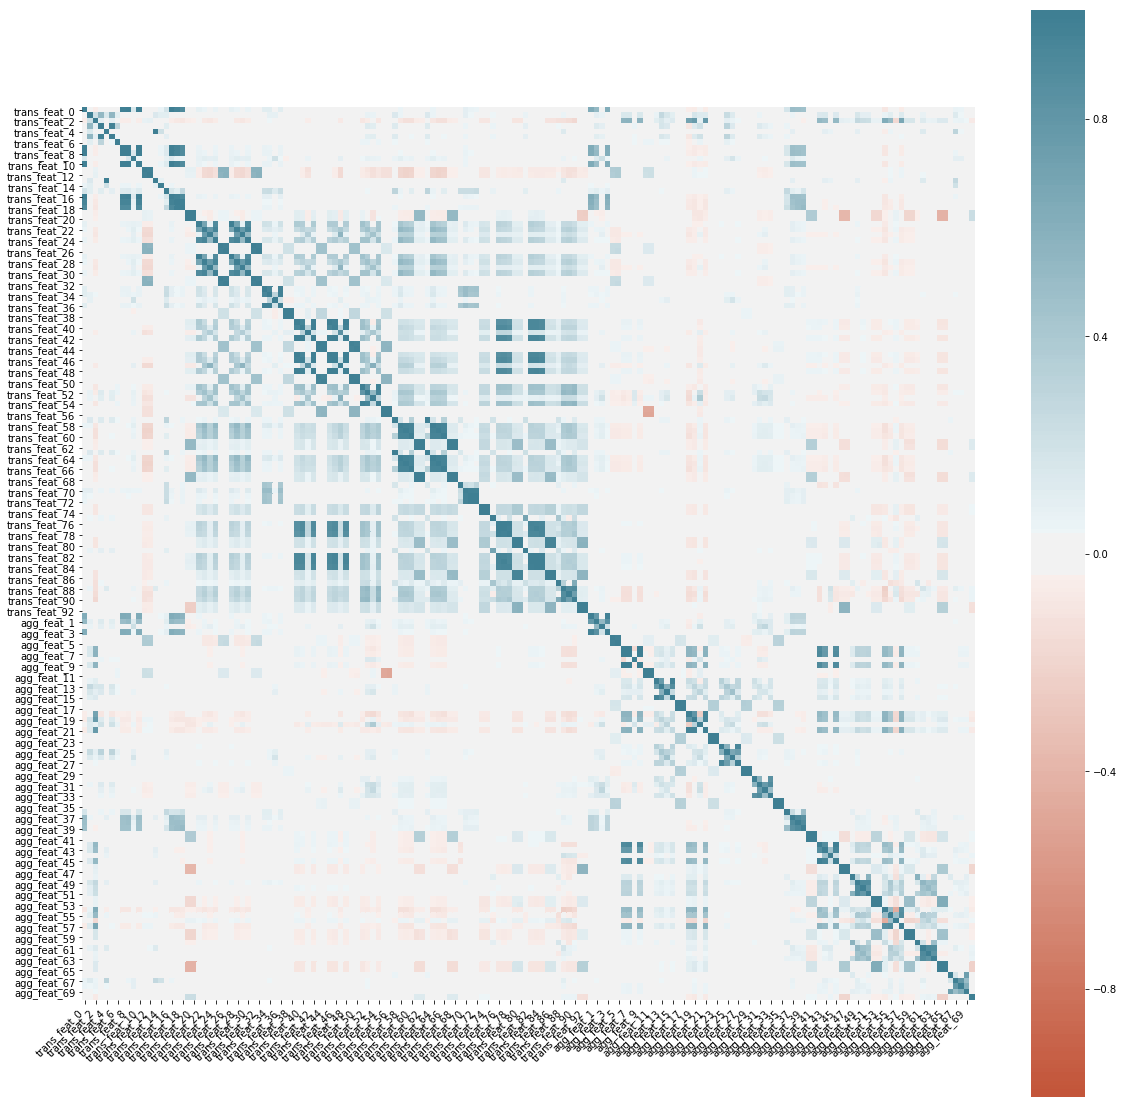

In [0]:
corr = df_features.iloc[:,2:-1].corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Let's also visualise number of different class transactions for each timestemp

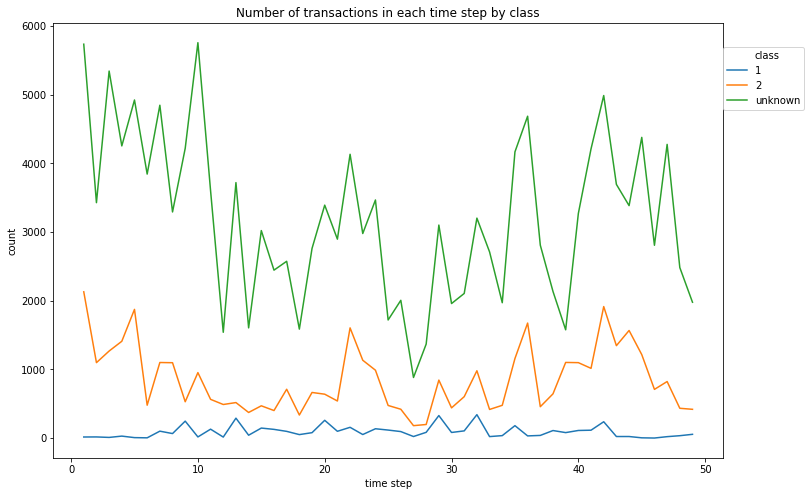

In [0]:
# merge with classes
df_features = pd.merge(df_features, df_classes, left_on='id', right_on='txId', how='left')

plt.figure(figsize=(12, 8))
grouped = df_features.groupby(['time step', 'class'])['id'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='time step', y='count', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by class');

Let's now identify the k most important features for the model and also take a look at them

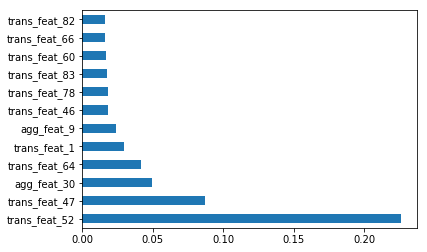

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(df_features.iloc[:, 2:-1], df_features.iloc[:,-1])
feat_importances = pd.Series(model.feature_importances_, index=df_features.iloc[:, 2:-1].columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

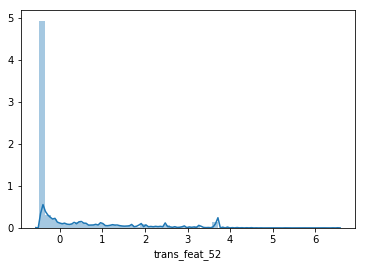

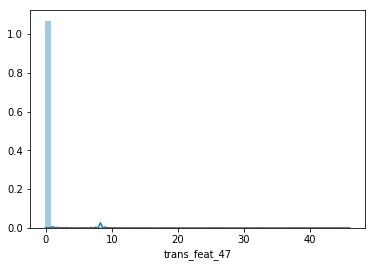

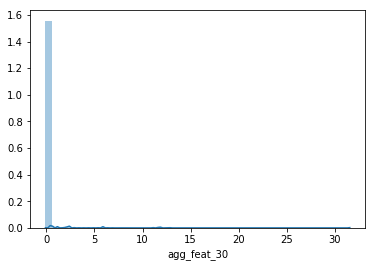

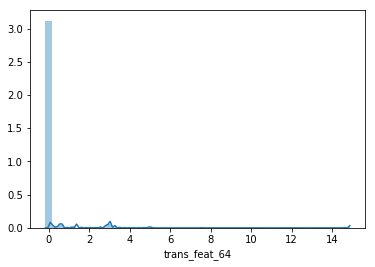

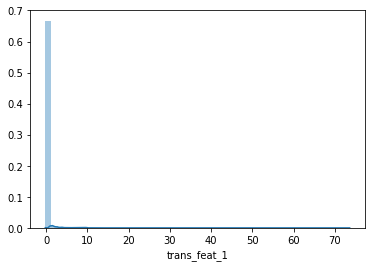

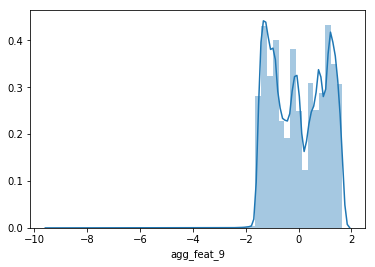

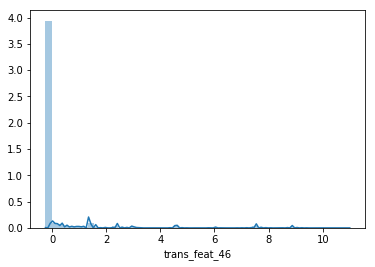

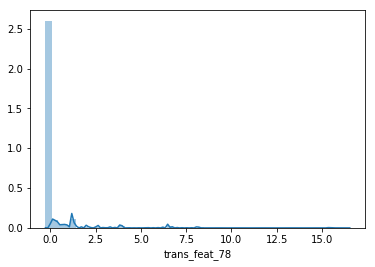

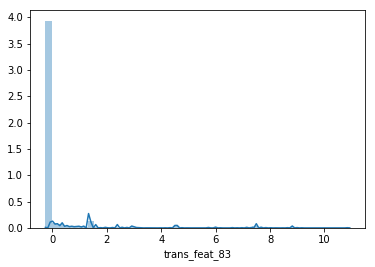

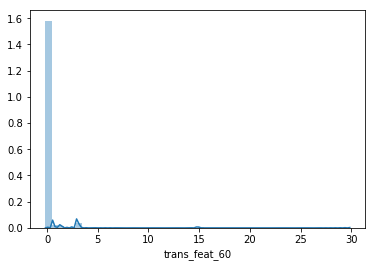

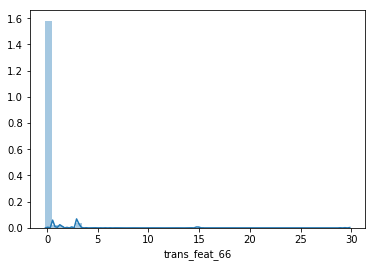

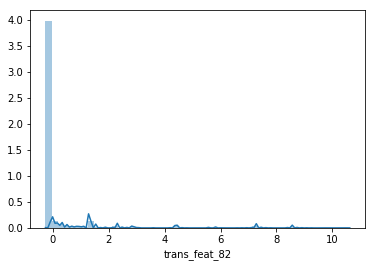

In [0]:
# distributions of each feature
for col in feat_importances.nlargest(12).index:
    sns.distplot(df_features[col])
    plt.show()

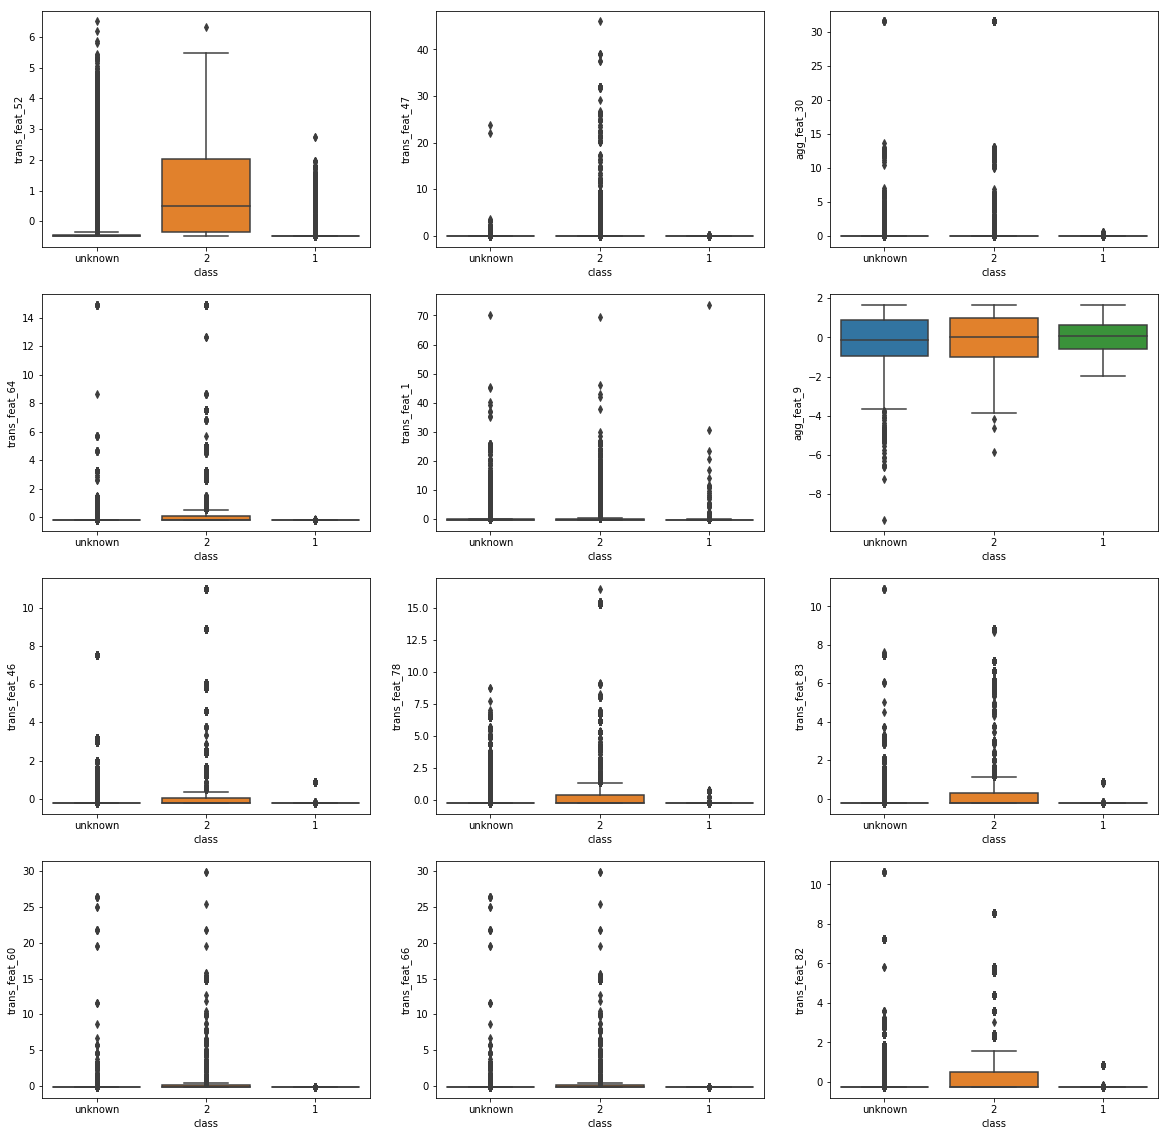

In [0]:
fig, ax = plt.subplots(4,3,figsize=(20,20))
for index, col in enumerate(feat_importances.nlargest(12).index):
    i,j = index % 3, index // 3
    g = sns.boxplot(y=col,x="class",ax = ax[j,i], data=df_features)

Also I want to plot the connections of the users who have made some illicit transactions to identify some malicious groups

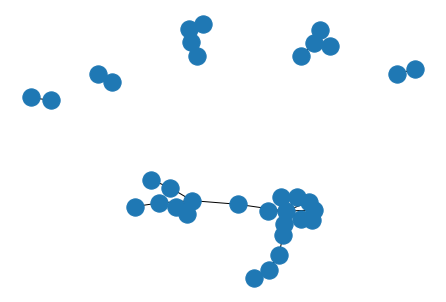

In [0]:
# taken from: https://www.kaggle.com/artgor/elliptic-data-eda
import networkx as nx
bad_ids = df_features.loc[(df_features['time step'] == 37) & (df_features['class'] == '1'), 'id']
short_edges = df_edgelist.loc[df_edgelist['txId1'].isin(bad_ids)]

graph1 = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.Graph())
pos1 = nx.spring_layout(graph1)
nx.draw(graph1, cmap = plt.get_cmap('rainbow'), with_labels=False, pos=pos1)


We can clearly see that some frauders work in groups, while others do their job alone

## Modelling

Here i will use **4** models to predict the feature class, also i will only use the data with known label, as unknown class label is not important for us

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report, log_loss, matthews_corrcoef


    
def get_stats(y_test, y_pred):
    stats_dict = {}
    stats_dict['Accuracy'] = accuracy_score(y_test, y_pred)
    stats_dict['F1'] = f1_score(y_test, y_pred)
    stats_dict['Precision'] = precision_score(y_test, y_pred)
    stats_dict['Recall'] = recall_score(y_test, y_pred)
    stats_dict['Logloss'] = log_loss(y_test, y_pred)
    stats_dict['Matthews corrcoef'] = matthews_corrcoef(y_test, y_pred)
    stats_dict['Confusion Matrix'] = confusion_matrix(y_test, y_pred)
    stats_dict['RocAuc'] = roc_auc_score(y_test, y_pred)
    
    return stats_dict

# main method which performs training, grid search and metrics measurment
def train_predict(model, train, grid_dict):
    
    X, y = train.iloc[:, 2:-1], train.iloc[:,-1]
    
    # train, valid split
    x_tr, x_val, y_tr, y_val = train_test_split(X, y, train_size = 0.8, shuffle = True)
    
    print("Training set has {} samples.".format(x_tr.shape[0]))
    print("Testing set has {} samples.".format(x_val.shape[0]))

    # do grid parameter search for the model and params
    grid_obj = GridSearchCV(model, param_grid = grid_dict, cv = KFold(n_splits = 5), n_jobs = 2)
    grid_fit = grid_obj.fit(x_tr,y_tr)

    # get the best classifier from grid search
    best_clf = grid_fit.best_estimator_
    
    # predict with best classifier from grid search
    y_pred = best_clf.predict(x_val)
    stats=get_stats(y_val, y_pred)
    
    return best_clf, stats

In [0]:
df_features = df_features[df_features['class'] != 'unknown']
df_features['class'] = df_features['class'].map({'1':0, '2':1})

train, test = train_test_split(df_features, train_size = 0.8)

### Logistic Regression

In [0]:
# Logistic Regression
model = LogisticRegression()
param_dict = {'C': [0.2, 0.5, 1]}

logreg, stats_lr = train_predict(model, train, param_dict)
print('Logreg stats ', stats_lr)

Training set has 29800 samples.
Testing set has 7451 samples.
Logreg stats  {'Accuracy': 0.903100254999329, 'F1': 0.949083215796897, 'Precision': 0.903100254999329, 'Recall': 1.0, 'Logloss': 3.3468761060891317, 'Matthews corrcoef': 0.0, 'Confusion Matrix': array([[   0,  722],
       [   0, 6729]]), 'RocAuc': 0.5}


### Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
param_dict = {'max_depth': [3,4,5,6,7]}

tree, stats_dt = train_predict(model, train, param_dict)
print('Decision tree stats ', stats_dt)

Training set has 29800 samples.
Testing set has 7451 samples.
Decision tree stats  {'Accuracy': 0.9810763655885116, 'F1': 0.9895917915405624, 'Precision': 0.9841432976068125, 'Recall': 0.9951009501187649, 'Logloss': 0.6536107674412661, 'Matthews corrcoef': 0.8872128755344748, 'Confusion Matrix': array([[ 607,  108],
       [  33, 6703]]), 'RocAuc': 0.9220259995349069}


### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
param_dict = {'max_depth': [3,4,5,6,7]}

rfc, stats_rf = train_predict(model, train, param_dict)
print('Random forest stats ', stats_rf)

Training set has 29800 samples.
Testing set has 7451 samples.
Random forest stats  {'Accuracy': 0.9759763790095289, 'F1': 0.986812053341192, 'Precision': 0.97453434225844, 'Recall': 0.9994030741680346, 'Logloss': 0.829765253555134, 'Matthews corrcoef': 0.8609697478136737, 'Confusion Matrix': array([[ 575,  175],
       [   4, 6697]]), 'RocAuc': 0.8830348704173506}


### Deep network

In [0]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras.metrics import binary_accuracy

def build_model():
    inp = Input(shape = (train.shape[1]-3,))
    x = Dense(64, activation = 'relu')(inp)
    x = Dense(32, activation = 'relu')(x)
    x = Dense(16, activation = 'relu')(x)
    out = Dense(1, activation = 'sigmoid')(x)
    net = Model(inputs = [inp], outputs = [out])
    net.compile(loss=[binary_crossentropy], optimizer=RMSprop(), metrics=[binary_accuracy])
    return net
kf = KFold(n_splits = 3)
for tr_idx, val_idx in kf.split(train):
    nnet = build_model()
    tr, vl = train.iloc[tr_idx, :], train.iloc[val_idx, :]
    X_tr, X_val = tr.iloc[:, 2:-1], vl.iloc[:, 2:-1]
    y_tr, y_val = tr.iloc[:, -1], vl.iloc[:,-1]
    
    nnet.fit(X_tr, y_tr, batch_size = 64, epochs = 3, verbose = 2)
    y_pred = nnet.predict(X_val)
    stats_nn= get_stats(y_val, y_pred)
    print(stats_nn)
nnet.fit(train.iloc[:,2:-1], train.iloc[:,-1])


Epoch 1/3
 - 2s - loss: 1.5606 - binary_accuracy: 0.9021
Epoch 2/3
 - 1s - loss: 1.5606 - binary_accuracy: 0.9021
Epoch 3/3
 - 1s - loss: 1.5606 - binary_accuracy: 0.9021
{'Accuracy': 0.9013449303374406, 'F1': 0.9481130077512813, 'Precision': 0.9013449303374406, 'Recall': 1.0, 'Logloss': nan, 'Matthews corrcoef': 0.0, 'Confusion Matrix': array([[    0,  1225],
       [    0, 11192]]), 'RocAuc': 0.5}
Epoch 1/3
 - 2s - loss: 1.5876 - binary_accuracy: 0.9004
Epoch 2/3
 - 1s - loss: 1.5876 - binary_accuracy: 0.9004
Epoch 3/3
 - 1s - loss: 1.5876 - binary_accuracy: 0.9004
{'Accuracy': 0.9047273898687284, 'F1': 0.949980973320367, 'Precision': 0.9047273898687284, 'Recall': 1.0, 'Logloss': nan, 'Matthews corrcoef': 0.0, 'Confusion Matrix': array([[    0,  1183],
       [    0, 11234]]), 'RocAuc': 0.5}
Epoch 1/3
 - 2s - loss: 14.5552 - binary_accuracy: 0.0970
Epoch 2/3
 - 1s - loss: 14.5552 - binary_accuracy: 0.0970
Epoch 3/3
 - 1s - loss: 14.5552 - binary_accuracy: 0.0970
{'Accuracy': 0.100507

### Predict & Evaluate

We can clearly see that linear models fail to extract data from the dataset, though tree models do a really good job. The best model so far is a decision tree as could be seen from the stat diagram below. 
<p>

 
I will now predict with all the models and compare the results on test set

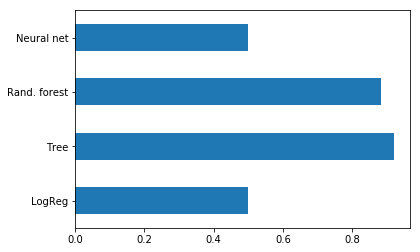

In [0]:
stats = pd.Series([stats_lr['RocAuc'], stats_dt['RocAuc'], stats_rf['RocAuc'], stats_nn['RocAuc']], index=['LogReg', 'Tree', 'Rand. forest', 'Neural net'])
stats.plot(kind='barh')
plt.show()

In [0]:
preds_tree = tree.predict(test.iloc[:,2:-1])
preds_logreg = logreg.predict(test.iloc[:,2:-1])
preds_rfc = rfc.predict(test.iloc[:,2:-1])
preds_nnet = nnet.predict(test.iloc[:,2:-1])
preds = pd.DataFrame(np.array([test.iloc[:,-1].values, preds_tree]).T, columns = ['True', 'Predicted'])

In [0]:
# final stats
final_statistics = pd.DataFrame(np.zeros((4,8)), columns = ['Model', 'Accuracy', 'F1', 'Precision', 'Recall', 'Logloss', 'Matthews corr', 'RocAuc'])
val = ['Tree'] + list(get_stats(test.iloc[:,-1].values, preds_tree).values())[:-2] + [list(get_stats(test.iloc[:,-1].values, preds_tree).values())[-1]]
final_statistics.iloc[0, :] = val
val = ['RFC'] + list(get_stats(test.iloc[:,-1].values, preds_rfc).values())[:-2] + [list(get_stats(test.iloc[:,-1].values, preds_rfc).values())[-1]]
final_statistics.iloc[1, :] = val
val = ['LogReg'] + list(get_stats(test.iloc[:,-1].values, preds_logreg).values())[:-2] + [list(get_stats(test.iloc[:,-1].values, preds_logreg).values())[-1]]
final_statistics.iloc[2, :] = val
val = ['Nnet'] + list(get_stats(test.iloc[:,-1].values, preds_nnet).values())[:-2] + [list(get_stats(test.iloc[:,-1].values, preds_nnet).values())[-1]]
final_statistics.iloc[3, :] = val
final_statistics.fillna('inf', inplace = True)
final_statistics

,Model,Accuracy,F1,Precision,Recall,Logloss,Matthews corr,RocAuc
0,Tree,0.983249,0.990787,0.985896,0.995726,0.578562,0.900061,0.930372
1,RFC,0.980457,0.989308,0.979298,0.999525,0.674992,0.882202,0.899650
2,LogReg,0.904542,0.949879,0.904542,1.000000,3.297078,0.000000,0.500000
3,Nnet,0.095458,0.000000,0.000000,0.000000,31.241775,0.000000,0.500000
